
# <span style="color:rgb(213,80,0)">Uniform LSUN (Locallay\-Structured Unitary Network)</span>

LSUN, like PCA, is a fully linear transformation.


Please do not forget to run **setpath** in the top directory of this package, and then return to this directory.


Requirements: MATLAB R2022a


 Contact address: Shogo MURAMATSU,


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Faculty of Engineering, Niigata University,


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 8050 2\-no\-cho Ikarashi, Nishi\-ku,


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Niigata, 950\-2181, JAPAN


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [http://msiplab.eng.niigata\-u.ac.jp](http://msiplab.eng.niigata-u.ac.jp)


 Copyright (c) 2022, Shogo MURAMATSU, All rights reserved.


In [1]:
clc, clear
isVisible = ~true;
dstfolder = support.fcn_download_img

NameError: name 'clc' is not defined

In [ ]:
imgfile = dstfolder + "kodim01.png";
img = im2double(rgb2gray(imread(imgfile)));

In [ ]:
% rblk = imd';
% nblocks = 9;
% blk = im2col(rblk,[14 14] ,'distinct')
nof = 1;
ky = 2*nof+1; % # of overlapping blocks (odd number)
kx = 2*nof+1;
disp([ky kx])

     3     3

In [ ]:
blksz = [4 4]; % Block size
% # of coeffs
nCoefs = 2;

## Global block PCA for reference

In [ ]:
% Reshape
colblks = im2col(img,blksz,"distinct");
% PCA
%Vpca = pca(colblks.')
mu = mean(colblks,2);
colblkszm = colblks - mu;
C = cov(colblkszm.');
[~,S,V] = svd(C,"econ");
[~,idxS] = sort(diag(S),"descend");
V = V(:,idxS(1:nCoefs));
%norm(Vpca - Vsvd,'fro')
% Approxiamtion
gbpcaimg = col2im(V*V.'*(colblks-mu)+mu,blksz,size(img),"distinct");

## Local block PCA for reference

In [ ]:
% % Create Sub-images
% s_img = createsubimg(blk);
[szy,szx] = size(img);
lbpcaimg = zeros(szy,szx);
for iBlkCol = 1:szx/blksz(2)
    for iBlkRow = 1:szy/blksz(1)
        % Extract ky x kx blocks
        subblks = fcn_extract_blks_(img,[iBlkRow,iBlkCol],blksz,[ky,kx]);
        % Reshape
        colblks = im2col(subblks,blksz,"distinct");
        % PCA
        %Vpca = pca(colblks.')
        mu = mean(colblks,2);
        colblkszm = colblks - mu;
        C = cov(colblkszm.');
        [~,S,V] = svd(C,"econ");
        [~,idxS] = sort(diag(S),"descend");
        V = V(:,idxS(1:nCoefs));
        %norm(Vpca - Vsvd,'fro')
        % Approxiamtion
        targetblk = fcn_extract_blks_(img,[iBlkRow,iBlkCol],blksz,[1 1]);
        targetblk = reshape(V*V.'*(targetblk(:)-mu)+mu,size(targetblk));
        % Place block
        lbpcaimg = fcn_place_blks_(lbpcaimg,targetblk,[iBlkRow,iBlkCol],blksz);
    end
end

## Locally Structured Unitary Network (LSUN) for 2\-D Grayscale image

In [ ]:
% Decimation factor (Strides)
stride = blksz; % [My Mx]

% Number of overlapping blocks (Polyphase order plus one)
ovlpFactor = [ky kx];

% Max epochs
maxEpochs = 64;

% Standard deviation of initial angles
stdInitAng = 0;

% No DC-leakage
noDcLeakage = true;

## Bivariate lattice\-structure of filter banks

As a base system for LSUN, let us adopt a multidimensional linear\-phase paraunitary filter banks (MD\-LPPUFB) ( or non\-separable oversampled lapped transform (NSOLT)) of  type\-I with the number of channels (the numbers of even and odd symmetric channels are identical to each other) and polyphase order (even):

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$$E(z_{{\mathrm{v}}} ,z_h )=\left(\prod_{k_{{\mathrm{h}}} =1}^{N_{{\mathrm{h}}} /2} V_{2k_{{\mathrm{h}}} }^{\lbrace {\mathrm{h}}\rbrace } \bar{Q} (z_{{\mathrm{h}}} )V_{2k_{{\mathrm{h}}} -1}^{\lbrace {\mathrm{h}}\rbrace } Q(z_{{\mathrm{h}}} )\right)\left(\prod_{k_{{\mathrm{v}}} =1}^{N_{{\mathrm{v}}} /2} V_{2k_{{\mathrm{v}}} }^{\lbrace {\mathrm{v}}\rbrace } \bar{Q} (z_{{\mathrm{v}}} )V_{2k_{{\mathrm{v}}} -1}^{\lbrace {\mathrm{v}}\rbrace } Q(z_{{\mathrm{v}}} )\right)V_0 E_0 ,$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$$R(z_{{\mathrm{v}}} ,z_h )=E^T (z_{{\mathrm{v}}}^{-1} ,z_{{\mathrm{h}}}^{-1} ),$$

where

-  $E(z_{{\mathrm{v}}} ,z_{{\mathrm{h}}} )$ :  Type\-I polyphase matrix of the analysis filter bank
-  $R(z_{{\mathrm{v}}} ,z_{{\mathrm{h}}} )$ : Type\-II polyphase matrix in the synthesis filter bank
-  $z_d \in \mathbb{C},d\in \lbrace {\mathrm{v}},{\mathrm{h}}\rbrace$ : The parameter of Z\-transformation direction
-  $N_d \in \mathbb{N},d\in \lbrace {\mathrm{v}},{\mathrm{h}}\rbrace$ : Polyphase order in direction $d$ (number of overlapping blocks)
-  $V_0 =\left(\begin{array}{cc} W_0  & O\newline O & U_0  \end{array}\right)\left(\begin{array}{c} I_{M/2} \newline O\newline I_{M/2} \newline O \end{array}\right)\in {\mathbb{R}}^{P\times M}$ , $V_n^{\lbrace d\rbrace } =\left(\begin{array}{cc} I_{P/2}  & O\newline O & U_n^{\lbrace d\rbrace }  \end{array}\right)\in {\mathbb{R}}^{P\times P} ,d\in \lbrace {\mathrm{v}},{\mathrm{h}}\rbrace$ , where $W_0 ,U_0 ,U_n^{\lbrace d\rbrace } \in {\mathbb{R}}^{P/2\times P/2}$ are orthonromal matrices.
-  $Q(z)=B_P \left(\begin{array}{cc} I_{P/2}  & O\newline O & z^{-1} I_{P/2}  \end{array}\right)B_P$ , $\bar{Q} (z)=B_P \left(\begin{array}{cc} zI_{P/2}  & O\newline O & I_{P/2}  \end{array}\right)B_P$ , $B_P =\frac{1}{\sqrt{2}}\left(\begin{array}{cc} I_{P/2}  & I_{P/2} \newline I_{P/2}  & -I_{P/2}  \end{array}\right)$

【Example】For $P/2=3$ , a parametric orthonormal matrix $U({\theta },{\mu })$ can be constructed by

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$$U({\theta },{\mu })\colon =\left(\begin{array}{ccc} \mu_1  & 0 & 0\newline 0 & \mu_1  & 0\newline 0 & 0 & \mu_2  \end{array}\right)\left(\begin{array}{ccc} 1 & 0 & 0\newline 0 & \cos \theta_2  & -\sin \theta_2 \newline 0 & \sin \theta_2  & \cos \theta_2  \end{array}\right)\left(\begin{array}{ccc} \cos \theta_1  & 0 & -\sin \theta_1 \newline 0 & 1 & 0\newline \sin \theta_1  & 0 & \cos \theta_1  \end{array}\right)\left(\begin{array}{ccc} \cos \theta_0  & -\sin \theta_0  & 0\newline \sin \theta_0  & \cos \theta_0  & 0\newline 0 & 0 & 1 \end{array}\right),$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$${U({\theta },{\mu })}^T =\left(\begin{array}{ccc} \cos \theta_0  & \sin \theta_0  & 0\newline -\sin \theta_0  & \cos \theta_0  & 0\newline 0 & 0 & 1 \end{array}\right)\left(\begin{array}{ccc} \cos \theta_1  & 0 & \sin \theta_1 \newline 0 & 1 & 0\newline -\sin \theta_1  & 0 & \cos \theta_1  \end{array}\right)\left(\begin{array}{ccc} 1 & 0 & 0\newline 0 & \cos \theta_2  & \sin \theta_2 \newline 0 & -\sin \theta_2  & \cos \theta_2  \end{array}\right)\left(\begin{array}{ccc} \mu_0  & 0 & 0\newline 0 & \mu_1  & 0\newline 0 & 0 & \mu_2  \end{array}\right),$$

where ${\theta }\in {\mathbb{R}}^{(P-2)P/8}$ and ${\mu }=\lbrace -1,1\rbrace^{P/2}$ . For the sake of simplification, the sign parameters $\mu_k$ are fixed to $-1$ for $U_n^{\lbrace d\rbrace }$ witn odd $n$ , otherwise they are fixed to $+1$ .


Partial differentiation can be, for examle, conducted as

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$$\frac{\partial }{\partial \theta_1 }{U({\theta },{\mu })}^T =\left(\begin{array}{ccc} \cos \theta_0  & \sin \theta_0  & 0\newline -\sin \theta_0  & \cos \theta_0  & 0\newline 0 & 0 & 1 \end{array}\right)\left(\begin{array}{ccc} -\sin \theta_1  & 0 & \cos \theta_1 \newline 0 & 0 & 0\newline -\cos \theta_1  & 0 & -\sin \theta_1  \end{array}\right)\left(\begin{array}{ccc} 1 & 0 & 0\newline 0 & \cos \theta_2  & \sin \theta_2 \newline 0 & -\sin \theta_2  & \cos \theta_2  \end{array}\right)\left(\begin{array}{ccc} \mu_0  & 0 & 0\newline 0 & \mu_1  & 0\newline 0 & 0 & \mu_2  \end{array}\right).$$


A locally\-structured unitary network (LSUN) allows to change the parameters block by block.


【References】

-  MATLAB SaivDr Package: [https://github.com/msiplab/SaivDr](https://github.com/msiplab/SaivDr)
-  S. Muramatsu, K. Furuya and N. Yuki, "Multidimensional Nonseparable Oversampled Lapped Transforms: Theory and Design," in IEEE Transactions on Signal Processing, vol. 65, no. 5, pp. 1251\-1264, 1 March1, 2017, [doi: 10.1109/TSP.2016.2633240](https://ieeexplore.ieee.org/document/7762239).
-  S. Muramatsu, T. Kobayashi, M. Hiki and H. Kikuchi, "Boundary Operation of 2\-D Nonseparable Linear\-Phase Paraunitary Filter Banks," in IEEE Transactions on Image Processing, vol. 21, no. 4, pp. 2314\-2318, April 2012, doi: 10.1109/TIP.2011.2181527.
-  S. Muramatsu, M. Ishii and Z. Chen, "Efficient parameter optimization for example\-based design of nonseparable oversampled lapped transform," 2016 IEEE International Conference on Image Processing (ICIP), Phoenix, AZ, 2016, pp. 3618\-3622, doi: 10.1109/ICIP.2016.7533034.
-  Furuya, K., Hara, S., Seino, K., & Muramatsu, S. (2016). Boundary operation of 2D non\-separable oversampled lapped transforms. *APSIPA Transactions on Signal and Information Processing, 5*, E9. doi:10.1017/ATSIP.2016.3.
-  S. Muramatsu, A. Yamada and H. Kiya, "A design method of multidimensional linear\-phase paraunitary filter banks with a lattice structure," in IEEE Transactions on Signal Processing, vol. 47, no. 3, pp. 690\-700, March 1999,[doi: 10.1109/78.747776](https://ieeexplore.ieee.org/document/747776).
### Definition of custom layers and networks

Use a custom layer of Deep Learning Toolbox to implement Analysis LSUN.

#### Definition of layers w/ Learnable properties
-  Initial rotation: $V_{0,b}$ (tansacnet.lsun.lsunInitialRotationLayer)
-  Intermediate rotation: $V_{n,b}^{\lbrace d\rbrace }$ (tansacnet.lsun.lsunIntermediateRotationLayer)
#### Definition of layers w/o Learnable properties
-  Bivariate DCT (2\-D IDCT): $E_0$ (tansacnet.lsun.lsunBlockDctLayer)
-  Vertical up extension: $Q(z_{{\mathrm{v}}} )$ (tansacnet.lsun.lsunAtomExtensionLayer)
-  Vertical down extension: $\bar{Q} (z_{{\mathrm{v}}} )$  (tansacnet.lsun.lsunAtomExtensionLayer)
-  Horizontal left extension: $Q(z_{{\mathrm{h}}} )$ (tansacnet.lsun.lsunAtomExtensionLayer)
-  Horizontal right extension: $\bar{Q} (z_{{\mathrm{h}}} )$ (tansacnet.lsun.lsunAtomExtensionLayer)


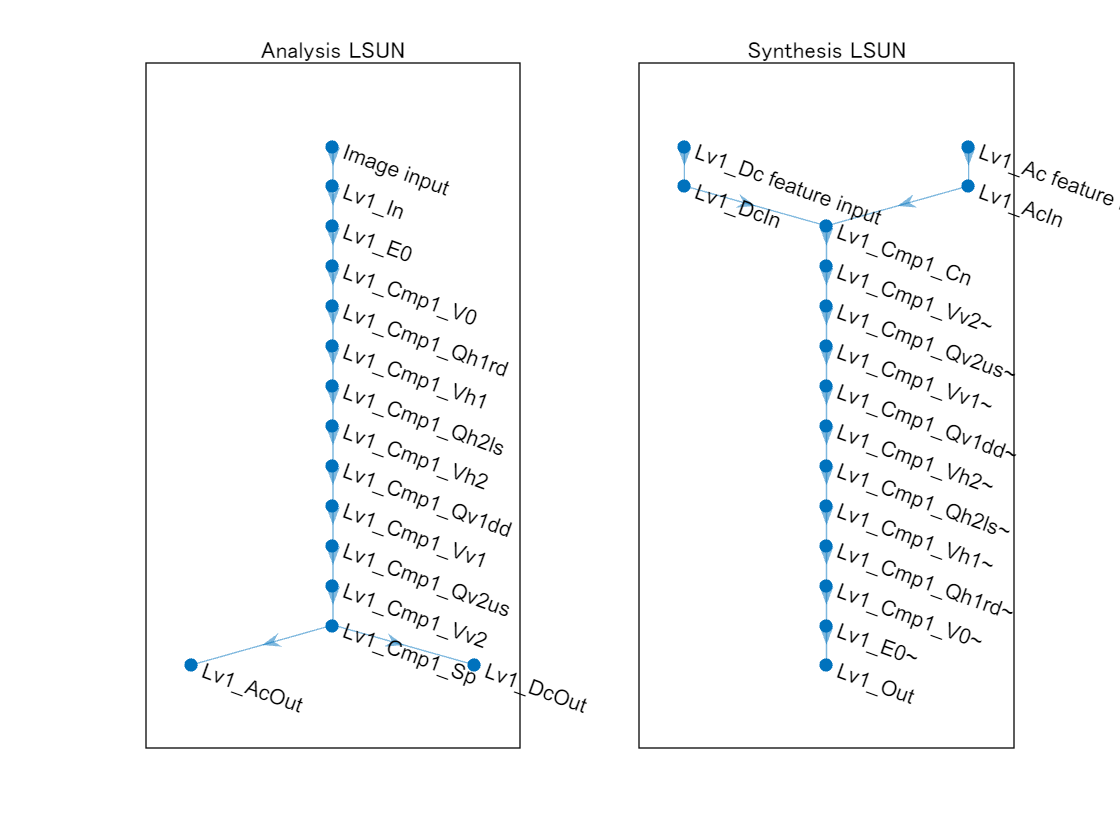

In [ ]:
import tansacnet.lsun.*
analysislgraph = fcn_createlsunlgraph2d([],...
    'InputSize',[szy szx],...
    'Stride',stride,...
    'OverlappingFactor',ovlpFactor,...
    'NumberOfVanishingMoments',noDcLeakage,...
    'Mode','Analyzer');
synthesislgraph = fcn_createlsunlgraph2d([],...
    'InputSize',[szy szx],...
    'Stride',stride,...
    'OverlappingFactor',ovlpFactor,...
    'NumberOfVanishingMoments',noDcLeakage,...
    'Mode','Synthesizer');
figure
subplot(1,2,1)
plot(analysislgraph)
title('Analysis LSUN')
subplot(1,2,2)
plot(synthesislgraph)
title('Synthesis LSUN')

In [ ]:

% Construction of synthesis network.
analysisnet = dlnetwork(analysislgraph);

% Initialize
nLearnables = height(analysisnet.Learnables);
for iLearnable = 1:nLearnables
    if analysisnet.Learnables.Parameter(iLearnable)=="Angles"
        analysisnet.Learnables.Value(iLearnable) = ...
            cellfun(@(x) x+stdInitAng*randn(size(x)), ...
            analysisnet.Learnables.Value(iLearnable),'UniformOutput',false);
    end
end

In [ ]:
import tansacnet.lsun.*
% Construction of analysis network
analysislgraph = layerGraph(analysisnet);
synthesislgraph = fcn_cpparamsana2syn(synthesislgraph,analysislgraph);

Copy angles from Lv1_Cmp1_V0 to Lv1_Cmp1_V0~
Copy angles from Lv1_Cmp1_Vh1 to Lv1_Cmp1_Vh1~
Copy angles from Lv1_Cmp1_Vh2 to Lv1_Cmp1_Vh2~
Copy angles from Lv1_Cmp1_Vv1 to Lv1_Cmp1_Vv1~
Copy angles from Lv1_Cmp1_Vv2 to Lv1_Cmp1_Vv2~

In [ ]:
synthesisnet = dlnetwork(synthesislgraph);


### Confirmation of the adjoint relation (perfect reconstruction)

In [ ]:
x = rand([szy szx],'single');
dlx = dlarray(x,'SSCB'); % Deep learning array (SSCB: Spatial,Spatial,Channel,Batch)
[dls{1:2}] = analysisnet.predict(dlx);
dly = synthesisnet.predict(dls{:});
display("MSE: " + num2str(mse(dlx,dly)))

    "MSE: 1.2916e-09"

## Parameter optimization and approximation


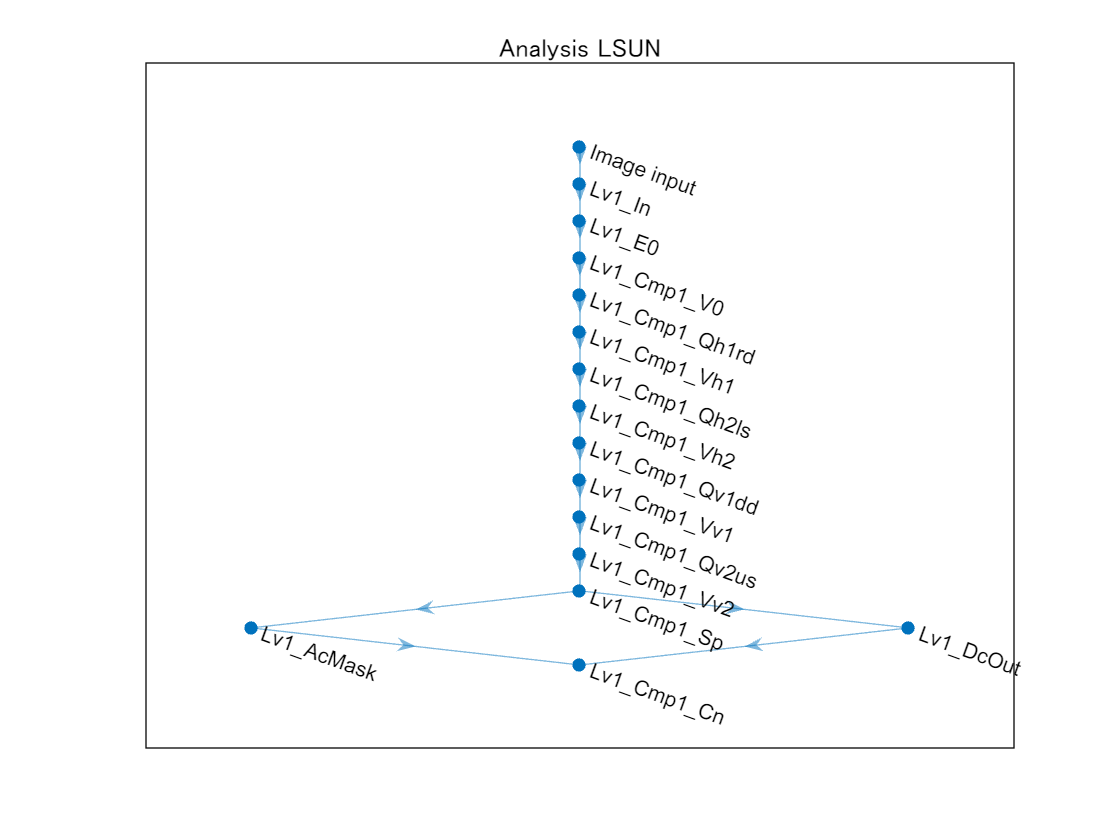

In [ ]:
import tansacnet.lsun.*
analysislgraph = layerGraph(analysisnet);

% Coefficient masking
nChsTotal = prod(stride);
coefMask = reshape([ones(nCoefs,1); zeros(nChsTotal-nCoefs,1)],2,[]).'; % Revised on Jan. 16, 2023
coefMask = coefMask(:);
%nLevels = 1;
%for iLv = nLevels:-1:1
iLv = 1;
strLv = sprintf('Lv%0d_',iLv);
% For AC
analysislgraph = analysislgraph.replaceLayer([strLv 'AcOut'],...
    maskLayer('Name',[strLv 'AcMask'],'Mask',coefMask(2:end),...
    'NumberOfChannels',nChsTotal-1));
%strLvPre = strLv;
%end

% Output layer
iCmp = 1;
strCmp = sprintf('Cmp%0d_',iCmp);
%analysislgraph = analysislgraph.addLayers([...
%      lsunChannelConcatenation2dLayer('Name',[strLv strCmp 'Cn']) ...
%      lsunRegressionLayer('Coefficient output')
%     ]);
analysislgraph = analysislgraph.addLayers(...
      lsunChannelConcatenation2dLayer('Name',[strLv strCmp 'Cn']));
analysislgraph = analysislgraph.connectLayers(...
    [strLv 'AcMask' ], [strLv strCmp 'Cn/ac']);
analysislgraph = analysislgraph.connectLayers(...
    [strLv 'DcOut' ], [strLv strCmp 'Cn/dc']);

figure
plot(analysislgraph)
title('Analysis LSUN')


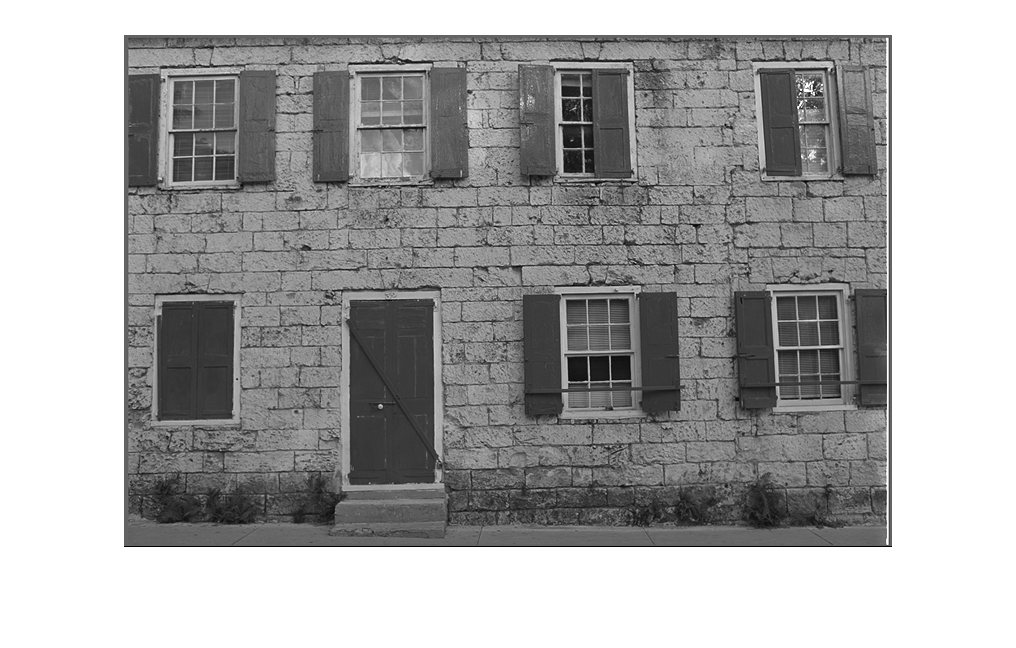

In [ ]:
% Image data store
fs = matlab.io.datastore.FileSet(imgfile);
imds = imageDatastore(imgfile,"ReadFcn",@(x) im2single(rgb2gray(imread(imgfile))));
%patchds = randomPatchExtractionDatastore(imds,imds,[szy szx],'PatchesPerImage',1);
figure
%minibatch = preview(patchds);
%inputimg = minibatch.InputImage;
imshow(preview(imds));

In [ ]:
drawnow
%figure
%responses = minibatch.ResponseImage;
%montage(responses,'Size',[2 4]);


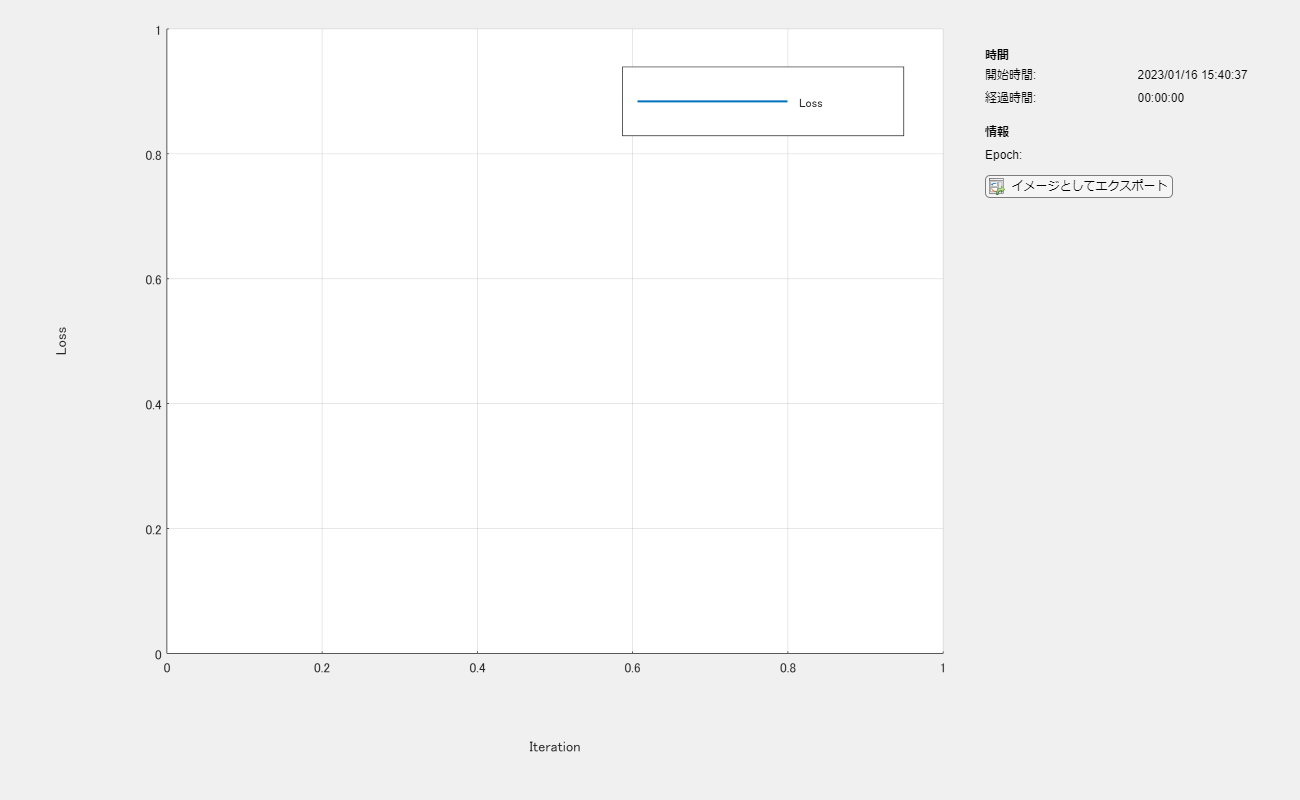

In [ ]:

dlX = dlarray(gpuArray(readimage(imds,1)),"SSCB");
trainnet = dlnetwork(analysislgraph,dlX);
assert(trainnet.Initialized)
%miniBatchSize = 1;
%mbq = minibatchqueue(patchds,...
%    'MiniBatchSize',miniBatchSize,...
%    'MiniBatchFormat',{'SSBC','SSBC'});
figure
monitor = trainingProgressMonitor(Metrics="Loss",Info="Epoch",XLabel="Iteration");

In [ ]:
% lineLossTrain = animatedline('Color',[0.85 0.325 0.098]);
% ylim([0 inf])
% xlabel("Iteration")
% ylabel("Loss")
% grid on



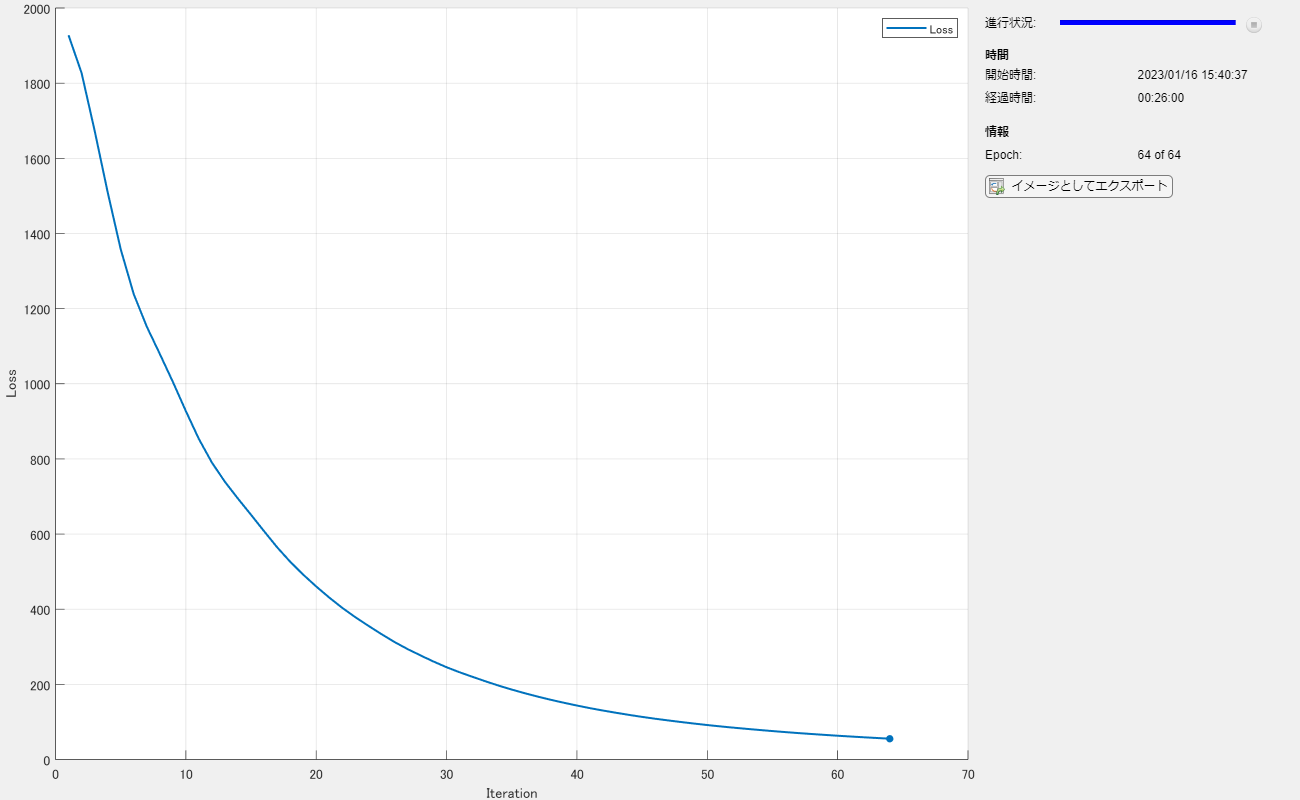

In [ ]:
numIterations = maxEpochs;

% Training
velocity = [];
iteration = 0;
momentum = 0.9;
decay = 0.01;
initialLearnRate = 1e-1;
epoch = 0;
start = tic;

% Loop over epochs.
while epoch < maxEpochs && ~monitor.Stop
    epoch = epoch + 1;
    % Shuffle data.
    %shuffle(mbq);
    shuffle(imds);

    % Loop over mini-batches.
    while hasdata(imds) && ~monitor.Stop % hasdata(mbq)
        iteration = iteration + 1;

        % Read mini-batch of data.
        %[dlX, T] = next(mbq);
        dlX = dlarray(gpuArray(read(imds)),"SSCB");

        % Evaluate the model gradients, state, and loss using dlfeval and the
        % modelGradients function and update the network state.
        [gradients,loss] = dlfeval(@modelGradients,trainnet,dlX);

        % Determine learning rate for time-based decay learning rate schedule.
        learnRate = initialLearnRate/(1 + decay*iteration);

        % Update the network parameters using the SGDM optimizer.
        [trainnet,velocity] = sgdmupdate(trainnet,gradients,velocity,learnRate,momentum);

        % Display the training progress.
        %D = duration(0,0,toc(start),'Format','hh:mm:ss');
        %addpoints(lineLossTrain,iteration,loss)
        %title("Epoch: " + epoch + ", Elapsed: " + string(D))
        %drawnow
        recordMetrics(monitor,iteration,Loss=loss);
        updateInfo(monitor,Epoch=epoch + " of " + maxEpochs);
        monitor.Progress = 100 * iteration/numIterations;
    end

    reset(imds);
end

## Approximation by LSUN\-base linear autoencoder

In [ ]:
import tansacnet.lsun.*
lsunlgraph = fcn_createlsunlgraph2d([],...
    'InputSize',[szy szx],...
    'Stride',stride,...
    'OverlappingFactor',ovlpFactor,...
    'NumberOfVanishingMoments',noDcLeakage,...
    'Mode','Whole');
trainlgraph = layerGraph(trainnet);
lsunlgraph = fcn_cpparamsana2syn(lsunlgraph,trainlgraph);

Copy angles from Lv1_Cmp1_V0 to Lv1_Cmp1_V0~
Copy angles from Lv1_Cmp1_Vh1 to Lv1_Cmp1_Vh1~
Copy angles from Lv1_Cmp1_Vh2 to Lv1_Cmp1_Vh2~
Copy angles from Lv1_Cmp1_Vv1 to Lv1_Cmp1_Vv1~
Copy angles from Lv1_Cmp1_Vv2 to Lv1_Cmp1_Vv2~

In [ ]:
lsunlgraph = fcn_cpparamssyn2ana(lsunlgraph,lsunlgraph);

Copy angles from Lv1_Cmp1_V0~ to Lv1_Cmp1_V0
Copy angles from Lv1_Cmp1_Vh1~ to Lv1_Cmp1_Vh1
Copy angles from Lv1_Cmp1_Vh2~ to Lv1_Cmp1_Vh2
Copy angles from Lv1_Cmp1_Vv1~ to Lv1_Cmp1_Vv1
Copy angles from Lv1_Cmp1_Vv2~ to Lv1_Cmp1_Vv2


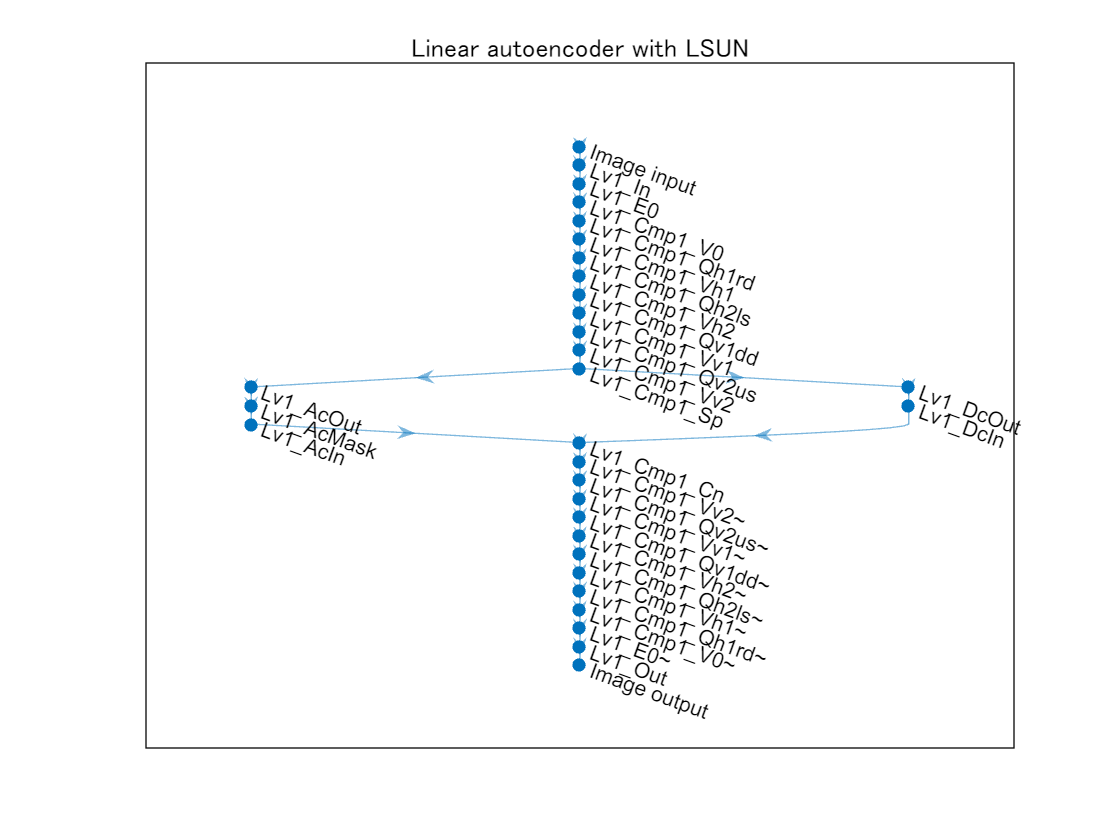

In [ ]:

%nLevels = 1;
%for iLv = nLevels:-1:1
iLv = 1;
strLv = sprintf('Lv%0d_',iLv);
lsunlgraph = lsunlgraph.disconnectLayers([strLv 'AcOut'],[strLv 'AcIn']);
% For AC
lsunlgraph = lsunlgraph.addLayers(...
    maskLayer('Name',[strLv 'AcMask'],'Mask',coefMask(2:end),...
    'NumberOfChannels',nChsTotal-1));
lsunlgraph = lsunlgraph.connectLayers([strLv 'AcOut'],[strLv 'AcMask']);
lsunlgraph = lsunlgraph.connectLayers([strLv 'AcMask'],[strLv 'AcIn']);
%strLvPre = strLv;
%end

figure
plot(lsunlgraph)
title('Linear autoencoder with LSUN')


Predict


In [ ]:
lsunnet = assembleNetwork(lsunlgraph);
lsunaimg = lsunnet.predict(img);

## Results


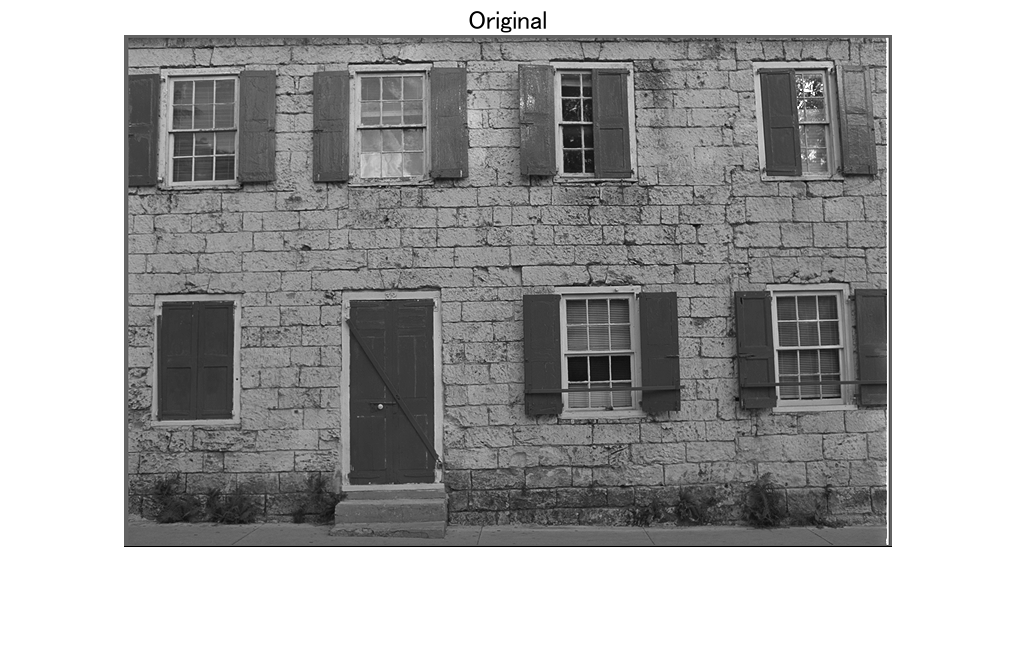

In [ ]:
figure
imshow(img)
title("Original")


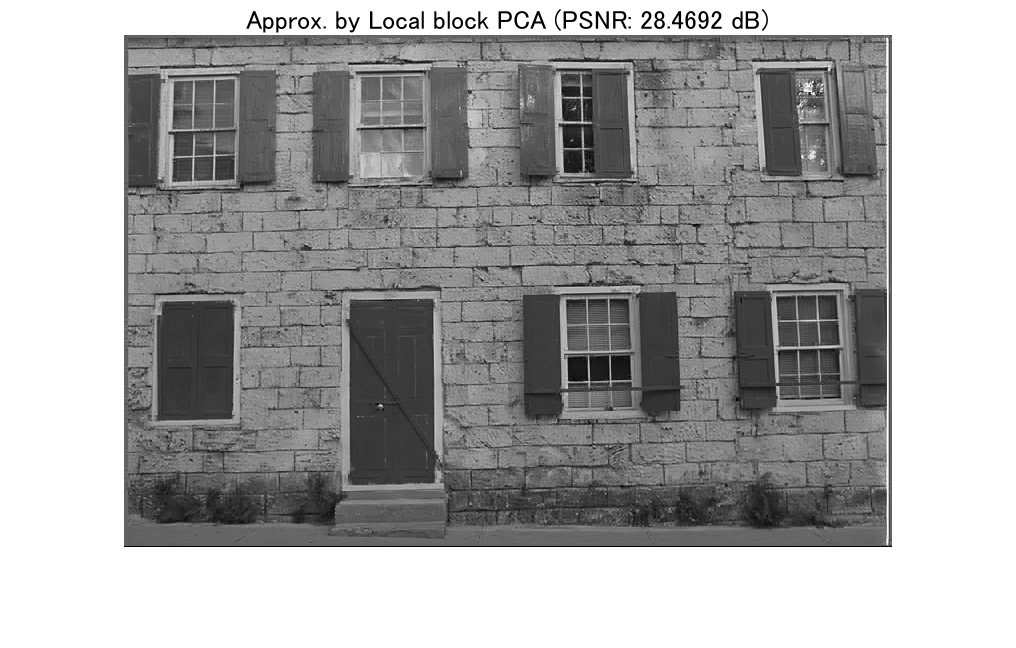

In [ ]:
figure
imshow(lbpcaimg)
title("Approx. by Local block PCA (PSNR: " + num2str(psnr(img,lbpcaimg))+" dB)")


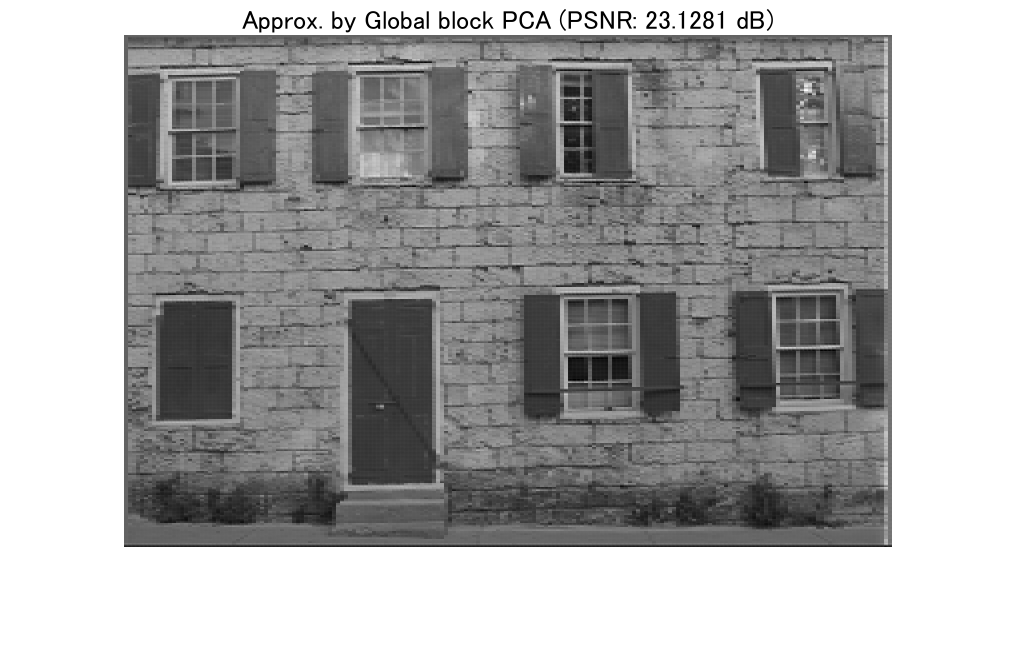

In [ ]:
figure
imshow(gbpcaimg)
title("Approx. by Global block PCA (PSNR: " + num2str(psnr(img,gbpcaimg))+" dB)")


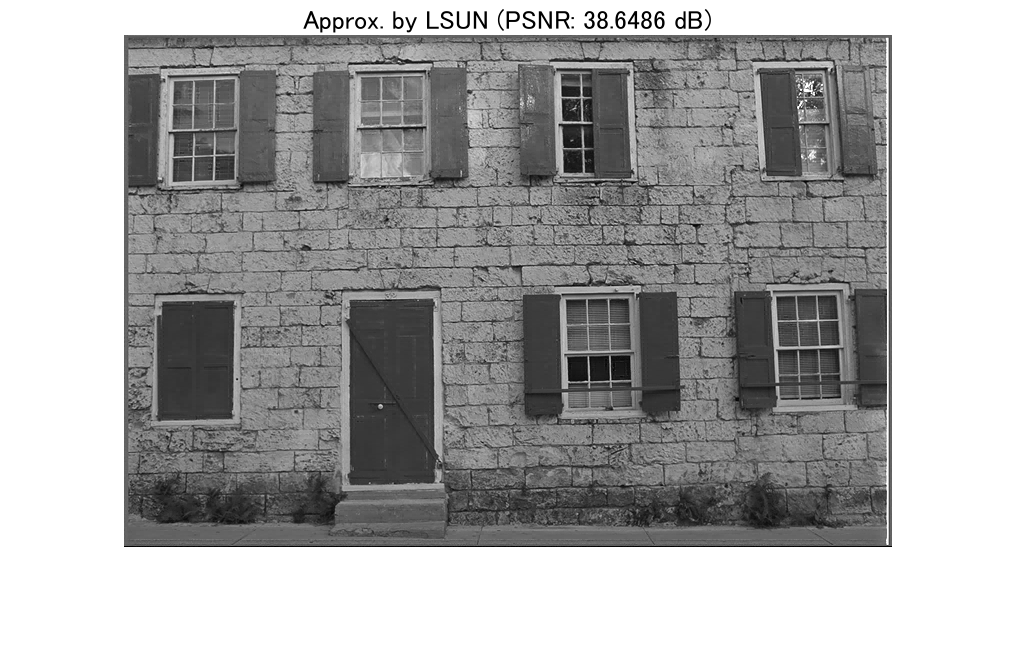

In [ ]:
figure
imshow(lsunaimg)
title("Approx. by LSUN (PSNR: " + num2str(psnr(img,im2double(lsunaimg)))+" dB)")

## Definitions of local functions

Function to extract a local patch block from a global array


In [ ]:
function y = fcn_extract_blks_(x,iBlk,blksz,k)
% Extend array x
ky = k(1);
kx = k(2);
iBlkRow = iBlk(1);
iBlkCol = iBlk(2);
padsz = [(ky-1)/2, (kx-1)/2].*blksz;
xx = padarray(x,padsz,"circular");
%
posy = (iBlkRow-1)*blksz(1)+1;
posx = (iBlkCol-1)*blksz(2)+1;
y = xx(posy:posy+ky*blksz(1)-1,posx:posx+kx*blksz(2)-1);
end


Function to place a local patch block to a global array


In [ ]:
function y = fcn_place_blks_(y,blk,iBlk,blksz)
% Extend array x
iBlkRow = iBlk(1);
iBlkCol = iBlk(2);
posy = (iBlkRow-1)*blksz(1)+1;
posx = (iBlkCol-1)*blksz(2)+1;
y(posy:posy+blksz(1)-1,posx:posx+blksz(2)-1) = blk;
end


Loss function


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $L({\theta })=\|x{\|}_2^2 -\|F_{{\theta }} (x){\|}_2^2$ ,


where $F_{{\theta }} (\cdot )$ is a unitaly analyzer with a coefficient mask. $L({\theta })\ge 0$ is guaranteed.


In [ ]:
function [gradients, loss] = modelGradients(dlnet, dlX)
% Forward data through the dlnetwork object.
dlY = forward(dlnet,dlX); % F(x)
% Compute loss.
Nx = size(dlX,4);
Ny = size(dlY,4);
loss = sum(dlX.^2,"all")/Nx-sum(dlY.^2,"all")/Ny;
% Compute gradients.
gradients = dlgradient(loss,dlnet.Learnables);
loss = double(gather(extractdata(loss)));
end